<a href="https://colab.research.google.com/github/Cflalex/-Practicum/blob/main/StartUp_PipeLine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Точность на тренировочных данных: 0.98
Точность на тестовых данных: 0.98


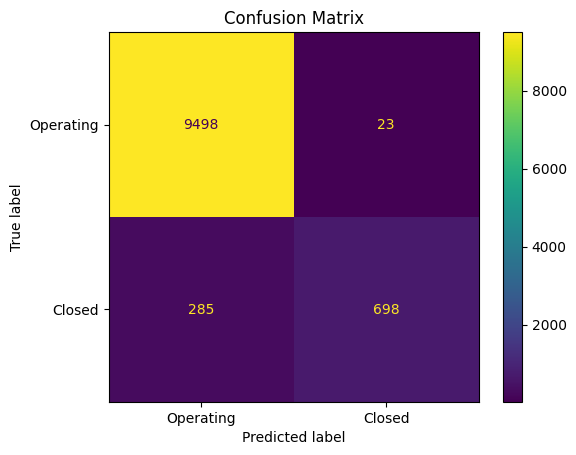

Файл для сабмита сохранен как 'submission.csv'.


<ipython-input-1-ab435036cd08>:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['status'] = submission['status'].map({1: 'operating', 0: 'closed'})


In [1]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Загружаем данные
data = pd.read_csv('/content/kaggle_startups_train_28062024.csv',
                   parse_dates=['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at'])

# Целевая переменная
data['status'] = data['status'].map({'operating': 1, 'closed': 0})

# Выделяем признаки и цель
X = data.drop(columns=['status', 'name', 'last_funding_at'])  # Оставляем 'closed_at' для использования в create_features
y = data['status']

# Обработка данных
current_date = pd.to_datetime('2018-01-01')

def create_features(df):
    if 'lifetime' not in df.columns:
        if 'closed_at' in df.columns:
            df['lifetime'] = (df['closed_at'].fillna(current_date) - df['founded_at']).dt.days
        else:
            df['lifetime'] = (current_date - df['founded_at']).dt.days
    if 'first_funding_at' in df.columns:
        df['days_since_first_funding'] = (current_date - df['first_funding_at']).dt.days
    else:
        df['days_since_first_funding'] = np.nan
    df['log_funding_total_usd'] = np.log1p(df['funding_total_usd'].fillna(0))
    if 'closed_at' in df.columns:
        df.drop(columns=['closed_at'], inplace=True)  # Теперь удаляем 'closed_at' после использования
    return df

# Пайплайн для обработки данных
categorical_features = ['category_list', 'country_code', 'state_code', 'region', 'city']
numerical_features = ['funding_rounds', 'lifetime', 'days_since_first_funding', 'log_funding_total_usd']

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Полный пайплайн с моделью
pipeline = Pipeline([
    ('features', FunctionTransformer(create_features)),
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Разделение данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели
pipeline.fit(X_train, y_train)

# Оценка модели
train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)

print(f"Точность на тренировочных данных: {train_score:.2f}")
print(f"Точность на тестовых данных: {test_score:.2f}")

# Предсказания вероятностей для тестовой выборки
probabilities = pipeline.predict_proba(X_test)[:, 1]  # Вероятности для класса "Operating"
threshold = 0.2
predictions = (probabilities >= threshold).astype(int)

# Матрица ошибок
cm = confusion_matrix(y_test, predictions, labels=[1, 0])
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Operating", "Closed"]).plot()
plt.title("Confusion Matrix")
plt.show()

# Подготовка данных для сабмита
submission_data = pd.read_csv('/content/kaggle_startups_test_28062024.csv',
                               parse_dates=[ 'first_funding_at', 'last_funding_at'])
submission_features = submission_data.drop(columns=['name', 'last_funding_at'])
submission_features = pipeline.named_steps['features'].transform(submission_features)
submission_probabilities = pipeline.predict_proba(submission_features)[:, 1]
submission_predictions = (submission_probabilities >= threshold).astype(int)

# Создание файла для сабмита
submission_data['status'] = submission_predictions
submission = submission_data[['name', 'status']]
submission['status'] = submission['status'].map({1: 'operating', 0: 'closed'})
submission.to_csv('/content/submission.csv', index=False)
print("Файл для сабмита сохранен как 'submission.csv'.")
